In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

  1%|          | 99/12501 [00:00<00:12, 980.76it/s]

PetImages/Cat


  1%|          | 126/12501 [00:00<00:09, 1259.15it/s]

PetImages/Dog


100%|██████████| 12501/12501 [00:10<00:00, 1242.56it/s]


Cats: 12476
Dogs: 12470


In [2]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [3]:
print(len(training_data))

24946


In [4]:
print(training_data[1])

[array([[146, 107, 125, ...,  82,  97,  62],
       [ 75,  93,  94, ...,  71,  87,  74],
       [ 83, 142,  98, ...,  73,  71,  89],
       ...,
       [ 41,  59,  55, ...,  84,  91,  94],
       [109,  73,  84, ...,  91,  98,  90],
       [ 94, 119, 106, ...,  97,  78,  68]], dtype=uint8)
 array([0., 1.])]


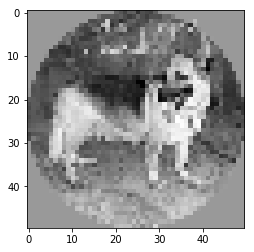

In [6]:
import matplotlib.pyplot as plt
plt.imshow(training_data[7][0], cmap="gray")
plt.show()

In [7]:


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) ##kernel sizeis 5
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        
        self._to_linear = None
        self.convs(x) ##part of forward method
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)
    
net = Net()
        

In [8]:


optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [9]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [13]:
BATCH_SIZE = 100
EPOCHS = 1
def train(net):   
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):

            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs,batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}. Loss: {loss}")

In [14]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1,1,50,50))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total,3))

In [15]:
torch.cuda.is_available()

True

In [16]:
train(net)

100%|██████████| 225/225 [00:16<00:00, 13.75it/s]

Epoch: 0. Loss: 0.1546812355518341


In [17]:
test(net)

100%|██████████| 2494/2494 [00:01<00:00, 1265.47it/s]

Accuracy:  0.725


In [18]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on cpu")

Running on GPU


In [21]:
torch.cuda.device_count() ##how many gpus

1

In [22]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [23]:
net = Net().to(device)

In [44]:
EPOCHS = 5
def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    BATCH_SIZE = 100

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):

            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]
            
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs,batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}. Loss: {loss}")
train(net)

  7%|▋         | 16/225 [00:00<00:01, 158.11it/s]

Epoch: 0. Loss: 0.03047358989715576


  7%|▋         | 15/225 [00:00<00:01, 147.60it/s]

Epoch: 1. Loss: 0.0010193006601184607


  7%|▋         | 16/225 [00:00<00:01, 155.41it/s]

Epoch: 2. Loss: 0.007594328839331865


  7%|▋         | 16/225 [00:00<00:01, 151.31it/s]

Epoch: 3. Loss: 0.00150962988846004


100%|██████████| 225/225 [00:01<00:00, 153.65it/s]

Epoch: 4. Loss: 0.048714425414800644


In [39]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1,1,50,50).to(device))[0]
            predicted_class = torch.argmax(net_out)
            
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total,3))
test(net)

100%|██████████| 2494/2494 [00:01<00:00, 2021.43it/s]

Accuracy:  0.749


In [45]:
train(net)

  7%|▋         | 16/225 [00:00<00:01, 159.48it/s]

Epoch: 0. Loss: 0.02070711925625801


  7%|▋         | 16/225 [00:00<00:01, 155.85it/s]

Epoch: 1. Loss: 0.01635047420859337


  7%|▋         | 16/225 [00:00<00:01, 152.81it/s]

Epoch: 2. Loss: 3.9552901398565155e-06


  7%|▋         | 15/225 [00:00<00:01, 146.76it/s]

Epoch: 3. Loss: 0.00018156584701500833


100%|██████████| 225/225 [00:01<00:00, 143.55it/s]

Epoch: 4. Loss: 0.0004268998163752258


In [46]:
test(net)

100%|██████████| 2494/2494 [00:00<00:00, 2545.52it/s]

Accuracy:  0.761
